In [1]:
library(scWGCNA)
library(Seurat)
library(parallel)
                  library(tidyverse)
                  library(data.table)
suppressMessages({
    library(data.table)
    library(irlba)
    library(stringr)
    library(Seurat)
    library(ggplot2)
    library(ggpubr)
    library(dplyr)
    library(patchwork)
    library(RColorBrewer)
    library(reshape2)
    library(scales)
    library(ggplotify)
    library(viridis)
    library(Matrix)
    library(harmony)
    library(ComplexHeatmap)
    library(circlize)
    library(ggh4x)
})

# library(scico)
theme_set(theme_bw())
source("/Users/Aking/Nutstore Files/我的坚果云//博后//代码//scgene_test.R")

ERROR: Error in library(scWGCNA): there is no package called ‘scWGCNA’


In [2]:
seurat_obj <- readRDS("seurat_obj.rds")

Warning message in gzfile(file, "rb"):
“cannot open compressed file 'seurat_obj.rds', probable reason 'No such file or directory'”


ERROR: Error in gzfile(file, "rb"): cannot open the connection


In [93]:
head(seurat_obj,2)

,orig.ident,nCount_RNA,nFeature_RNA,sample,cell,cluster_number,cluster_name,RA_status,cell_type,UMAP1,UMAP2,CTAP,RNA_snn_res.0.5,seurat_clusters
,<fct>,<dbl>,<int>,<chr>,<chr>,<fct>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<fct>,<fct>
BRI-399_AAACCCAAGTCATTGC,BRI-399,7959,2497,BRI-399,BRI-399_AAACCCAAGTCATTGC,F-6,F-6: CXCL12+ SFRP1+ sublining,0,Fibroblast,2.349461,5.222111,OA,1,1
BRI-399_AAACCCAAGTGAATAC,BRI-399,8601,3055,BRI-399,BRI-399_AAACCCAAGTGAATAC,F-9,Mu-0: Mural,0,Fibroblast,10.145320,-2.765873,OA,8,8


In [67]:
Idents(seurat_obj) <- "cluster_number"
seurat_sub <- subset(seurat_obj, idents = c("F-0","F-1"))

In [68]:
seurat_sub

An object of class Seurat 
33538 features across 25862 samples within 1 assay 
Active assay: RNA (33538 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 4 dimensional reductions calculated: pca, harmony, tsne, umap

In [69]:
# seurat_sub %>% head(2)
typeof(seurat_sub)
class(seurat_sub[["RNA"]])
class(seurat_sub)

[1] "S4"

[1] "Assay5"
attr(,"package")
[1] "SeuratObject"

[1] "Seurat"
attr(,"package")
[1] "SeuratObject"

In [75]:
Idents(seurat_sub) <- "seurat_clusters"

# Create a seurat of v3 

In [95]:
data_count <- seurat_sub[["RNA"]]$counts

saveRDS(data_count, file = "data_count.rds")


typeof(data_count)
# data_count[1:3,1:5]

sub_metadata <- seurat_sub[[]]
# sunset_metadata %>% head(2)
saveRDS(sub_metadata, file = "sub_metadata.rds")

[1] "S4"

In [25]:
# create v3 assays
options(Seurat.object.assay.version = "v3")
sub_seurat_v3 <- CreateSeuratObject(counts = data_count)
sub_seurat_v3
typeof(sub_seurat_v3)
class(sub_seurat_v3[["RNA"]])
class(sub_seurat_v3)

An object of class Seurat 
33538 features across 25862 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)
 2 layers present: counts, data

[1] "S4"

[1] "Assay"
attr(,"package")
[1] "SeuratObject"

[1] "Seurat"
attr(,"package")
[1] "SeuratObject"

In [17]:
saveRDS(sub_seurat_v3, file = "sub_seurat_v3.rds")

In [3]:
sub_seurat_v3 <- readRDS("../seurat_v3_object/sub_seurat_v3.rds")

In [4]:
head(sub_seurat_v3,2)

,orig.ident,nCount_RNA,nFeature_RNA,sample,cell,cluster_number,cluster_name,RA_status,cell_type,UMAP1,UMAP2,CTAP,RNA_snn_res.0.5,seurat_clusters,RNA_snn_res.0.6
,<fct>,<dbl>,<int>,<chr>,<chr>,<fct>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<fct>,<fct>,<fct>
BRI-399_AAACCCAGTGCTATTG,BRI-399,15926,4054,BRI-399,BRI-399_AAACCCAGTGCTATTG,F-0,F-0: PRG4+ CLIC5+ lining,0,Fibroblast,-0.6730293,-6.191035,OA,0,4,4
BRI-399_AAACGAAAGGCACAAC,BRI-399,26538,4934,BRI-399,BRI-399_AAACGAAAGGCACAAC,F-1,F-1: PRG4+ lining,0,Fibroblast,-2.4315333,-6.921932,OA,0,11,11


## run standard anlaysis workflow

In [23]:
# High variable genes
sub_seurat_v3 <- NormalizeData(sub_seurat_v3) %>% 
  FindVariableFeatures(selection.method = "vst",nfeatures = 3000) %>% 
  ScaleData() %>% 
  RunPCA(npcs = 30, verbose = T)

# Integration using Harmony
sub_seurat_v3 <- RunHarmony(sub_seurat_v3, group.by.vars = "orig.ident")

# Cluster
sub_seurat_v3 <- FindNeighbors(sub_seurat_v3, reduction = "harmony", dims = 1:20) %>% 
  FindClusters(resolution = 0.6) 

# t-SNE or UMAP
sub_seurat_v3 <- RunTSNE(sub_seurat_v3, reduction = "harmony", dims = 1:20)
sub_seurat_v3 <- RunUMAP(sub_seurat_v3, reduction = "harmony", dims = 1:20)

Centering and scaling data matrix

PC_ 1 
Positive:  PRELP, LUM, IGFBP7, TGFBI, DPT, SRGN, COMP, CHI3L2, ASPN, LTBP1 
	   FMOD, BGN, DCN, CAPG, AEBP1, VIM, OGN, TREM1, ACTN1, SOD3 
	   DKK3, COL6A1, THY1, COL3A1, C4orf48, NDUFA4L2, XIST, MXRA5, COL1A1, MT1F 
Negative:  CLIC5, GPR1, SPARCL1, HBEGF, DIRC3, THBS4, TSPAN7, GPX3, SCUBE1, PCSK6 
	   IGFBP5, CFD, EPB41L1, ERRFI1, TMEM196, KHDRBS3, LTBP4, ITGA6, RPS4Y1, TCIM 
	   CTTNBP2, OLFM3, TGFB2, COL22A1, TIMP3, EGR1, ADAMTSL1, TRHDE, HSPB1, DNASE1L3 
PC_ 2 
Positive:  PLTP, COL1A2, CXCL12, COL3A1, SPARC, PTGDS, ABI3BP, COL1A1, PCOLCE, TIMP1 
	   HLA-A, RAMP3, IGFBP5, COL5A2, VKORC1, FSTL1, LAMA4, HLA-DRA, THBS4, CD248 
	   HLA-B, DNASE1L3, TNC, PLXDC1, CD74, MGAT4C, ISLR, CCDC80, PPP1R1A, SEMA5A 
Negative:  GADD45B, MT1M, DUSP1, MT1E, MYC, CEBPD, SOCS3, KLF9, NFKBIA, CEBPB 
	   ZFP36, NFIL3, RGS16, MT2A, NAMPT, MT1X, RHOB, JUNB, NNMT, TIPARP 
	   MT1A, ATF3, FOS, C11orf96, NFKBIZ, ID2, CCNL1, RASD1, SAT1, KLF4 
PC_ 3 
Positive:  TNC, CO

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 25862
Number of edges: 788885

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8453
Number of communities: 15
Elapsed time: 2 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
10:45:29 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

10:45:29 Read 25862 rows and found 20 numeric columns

10:45:29 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

10:45:29 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:45:30 Writing NN index file to 

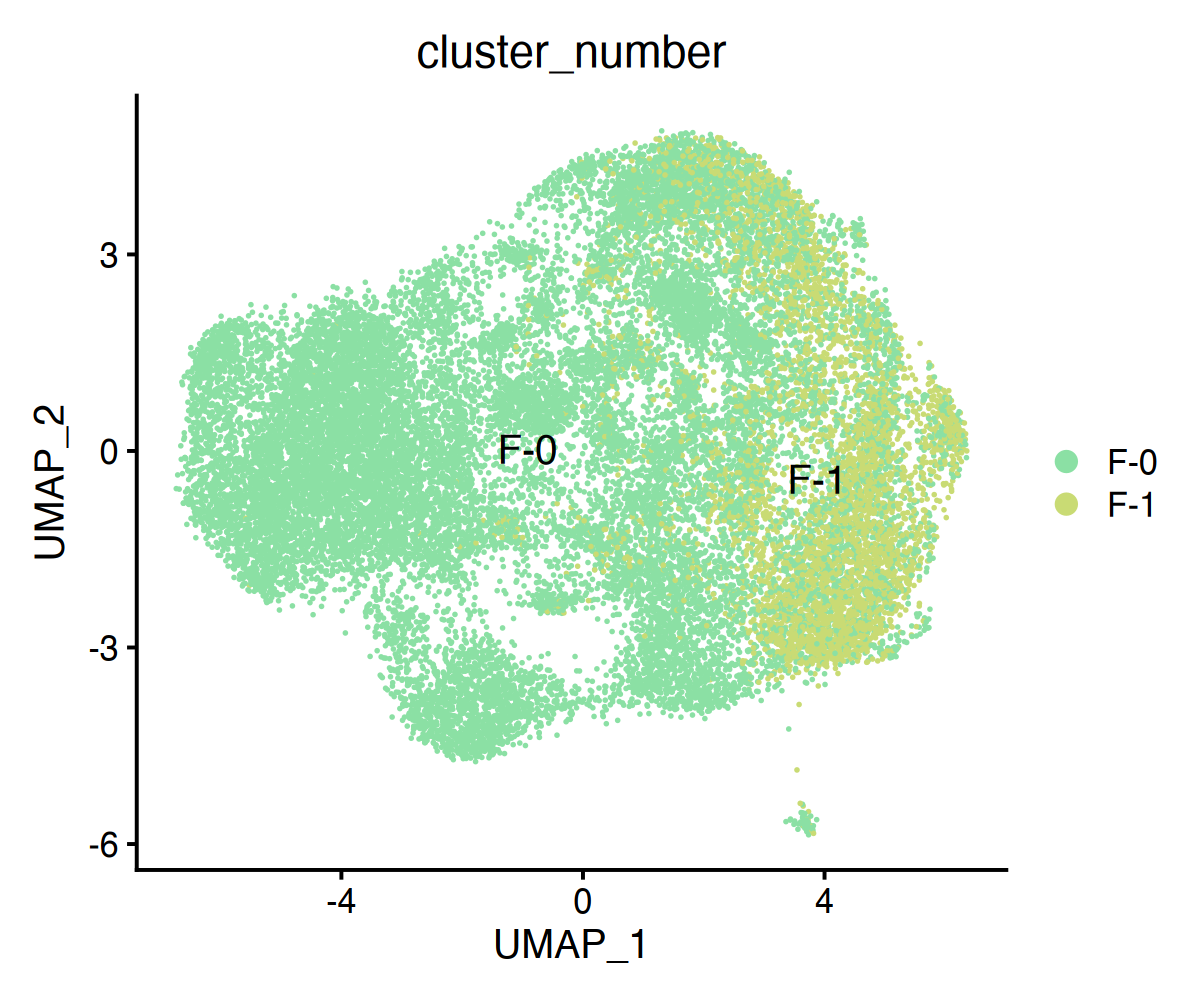

In [7]:
options(repr.plot.width = 6, repr.plot.height=5,repr.plot.res=200)
                     
umap_obj1 <- DimPlot(sub_seurat_v3,
                     group.by = "cluster_number",
                     pt.size = 0.01,
                     label.size = 5,
                     reduction = "umap", 
                     label = TRUE, 
                     cols = rev(my_col_18))
umap_obj1

In [24]:
sub_seurat_v3

An object of class Seurat 
33538 features across 25862 samples within 1 assay 
Active assay: RNA (33538 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 4 dimensional reductions calculated: pca, harmony, tsne, umap

# scWGCNA

### Calculate the pseudocells

In [ ]:
# Calculate the pseudocells
Fibro_sub.pcells = calculate.pseudocells(s.cells = sub_seurat_v3, # Single cells in Seurat object
                                          seeds=0.2, # Fraction of cells to use as seeds to aggregate pseudocells
                                          nn = 10, # Number of neighbors to aggregate
                                          reduction = "pca", # Reduction to use
                                          dims = 1:10) # The dimensions to use

Computing nearest neighbor graph

Computing SNN

Choosing seeds

21179 out of 25862 Cells will be agreggated into 5167 Pseudocells

Assining pseudocells

Aggregating pseudocell expression

As of Seurat v5, we recommend using AggregateExpression to perform pseudo-bulk analysis.
This message is displayed once per session.
Names of identity class contain underscores ('_'), replacing with dashes ('-')
This message is displayed once every 8 hours.
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”


In [ ]:
# Fibro_sub.pcells <- AggregateExpression(object = seurat_sub, slot = "counts",
#                                         assays = "RNA",
#                                         # group.by = c("CTAP","cluster_number"),
#                                         return.seurat = TRUE
#                                         )
# Fibro_sub.pcells

In [ ]:
head(Fibro_sub.pcells,2)

In [ ]:
tail(Cells(Fibro_sub.pcells))

In [83]:
# Run scWGCNA
Fibro_sub.scWGCNA = run.scWGCNA(p.cells = Fibro_sub.pcells, # Pseudocells (recommended), or Seurat single cells
                                 s.cells = sub_seurat_v3, # single cells in Seurat format
                                 is.pseudocell = T, # We are using single cells twice this time
                                 features = rownames(sub_seurat_v3)) # Recommended: variable genes

ERROR: Error in run.scWGCNA(p.cells = Fibro_sub.pcells, s.cells = sub_seurat_v3, : no slot of name "counts" for this object of class "Assay5"


## Modules of co-expression

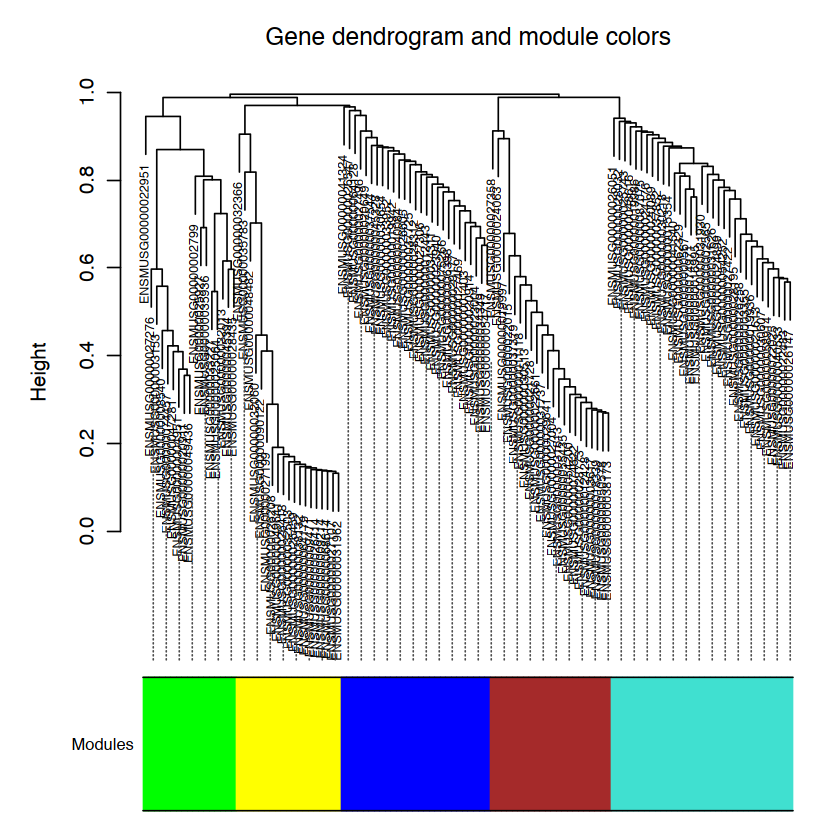

In [23]:
# Plot the gene / modules dendrogram
scW.p.dendro(scWGCNA.data = Fibro_sub.scWGCNA)

In [25]:
#Look at the membership tables
names(Fibro_sub.scWGCNA$modules)

[1] "1_blue"      "2_brown"     "3_green"     "4_turquoise" "5_yellow"

In [27]:
#Let's look at the first module, "blue"
head(Fibro_sub.scWGCNA$modules$`1_blue`)

,Membership,p.val
,<dbl>,<dbl>
ENSMUSG00000001403,0.8688156,2.911492e-16
ENSMUSG00000029177,0.7782598,2.901329e-11
ENSMUSG00000020649,0.5091048,1.596436e-04
ENSMUSG00000026547,0.3771343,6.938527e-03
ENSMUSG00000026605,0.8699181,2.408654e-16
ENSMUSG00000030654,0.7681162,7.490872e-11


In [39]:
# We use gene unique identifiers. For this reason we need to translate them to names
my.module = Fibro_sub.scWGCNA$modules$`1_blue`

In [41]:
# We have gene names translation in the misc slot of this seurat object.
my.gnames = seurat_sub@misc$gnames
head(my.gnames)

,Gene.stable.ID,Gene.name
,<chr>,<chr>
ENSMUSG00000068614,ENSMUSG00000068614,Actc1
ENSMUSG00000026459,ENSMUSG00000026459,Myog
ENSMUSG00000064179,ENSMUSG00000064179,Tnnt1
ENSMUSG00000047281,ENSMUSG00000047281,Sfn
ENSMUSG00000018339,ENSMUSG00000018339,Gpx3
ENSMUSG00000001506,ENSMUSG00000001506,Col1a1


In [33]:
# Look at the table again
my.module$gname = my.gnames[rownames(my.module), "Gene.name"]
head(my.module)

,Membership,p.val,gname
,<dbl>,<dbl>,<chr>
ENSMUSG00000001403,0.8688156,2.911492e-16,Ube2c
ENSMUSG00000029177,0.7782598,2.901329e-11,Cenpa
ENSMUSG00000020649,0.5091048,1.596436e-04,Rrm2
ENSMUSG00000026547,0.3771343,6.938527e-03,Tagln2
ENSMUSG00000026605,0.8699181,2.408654e-16,Cenpf
ENSMUSG00000030654,0.7681162,7.490872e-11,Arl6ip1


In [35]:
# Here we can see what is the expression of each co-expression module, per cell. This is in one of the list items
head(Fibro_sub.scWGCNA[["sc.MEList"]]$averageExpr)

,AEblue,AEbrown,AEgreen,AEturquoise,AEyellow
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CTTTGCGGTGCTAGCC,-0.5596879,-0.18997600,-0.1111647,0.29700486,-0.2587123
CAGCCGAAGTCACGCC,-0.5812957,0.15506053,-0.2422277,0.34152125,-0.2587123
GCGACCAAGAATCTCC,-0.6161389,0.32160113,-0.2422277,0.04568679,-0.2587123
TGACAACCACCTGGTG,-0.4772609,-0.01193024,-0.1263879,0.59076344,-0.2024361
TGCGCAGCAGCGTAAG,-0.5382255,-0.16473362,-0.0928799,0.52376012,-0.1964491
TGACTTTCAGACAAAT,-0.4241158,-0.17850570,-0.1346795,0.49186946,-0.1952610


In [37]:
# If we want to see the average module expression per pseudocell instead of single cells, we find it here
head(Fibro_sub.scWGCNA[["MEList"]]$averageExpr)

,AEblue,AEbrown,AEgreen,AEturquoise,AEyellow
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ACGCCAGCATCGGGTC,-0.5704408,-0.25087123,-0.1895993,0.4689498,-0.2271983
GGCGACTGTAGCTGCC,-0.7121218,0.04843604,-0.2167900,0.4118500,-0.1778088
ACGGGTCTCGCACTCT,-0.5405850,-0.14004902,-0.2371360,0.7580970,-0.2289374
CCGTTCACATGTAAGA,0.1071384,-0.15175634,-0.2693426,0.9344596,-0.2488376
ACCTTTAGTTCGGCAC,1.1476635,-0.14505818,-0.2175833,0.4129948,-0.2126678
AGGTCATAGTCGTACT,-0.7136724,-0.17375364,-0.3258270,0.4483282,-0.2835482


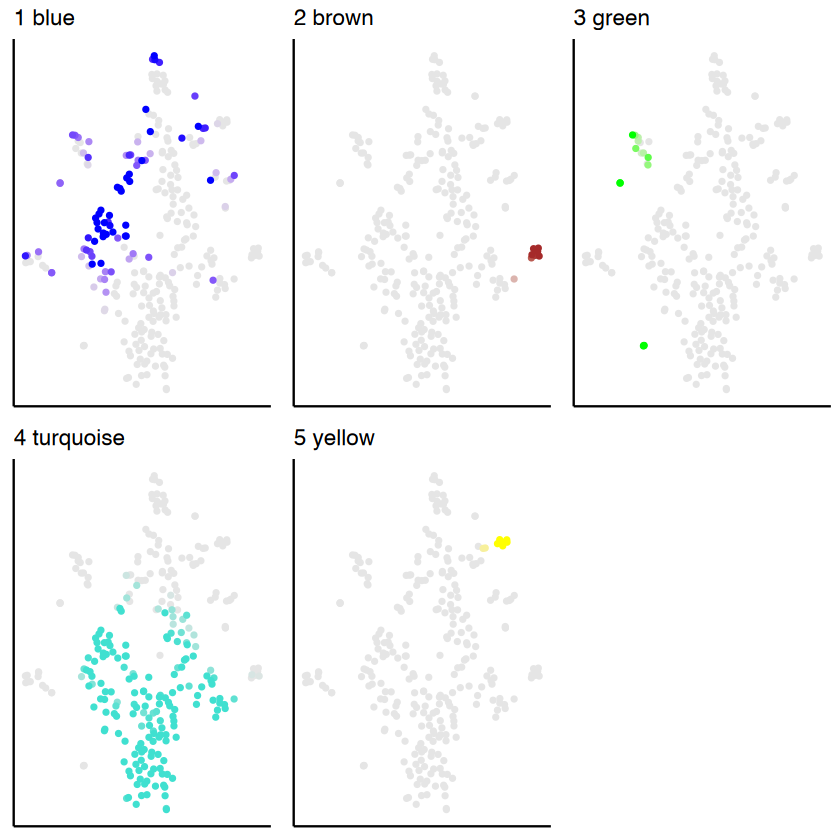

In [43]:
# Plot the expression of all modules at once
scW.p.expression(s.cells = seurat_sub, # Single cells in Seurat format
                       scWGCNA.data = Fibro_sub.scWGCNA, # scWGCNA list dataset
                       modules = "all", # Which modules to plot?
                       reduction = "tsne", # Which reduction to plot?
                       ncol=3) # How many columns to use, in case we're plotting several?

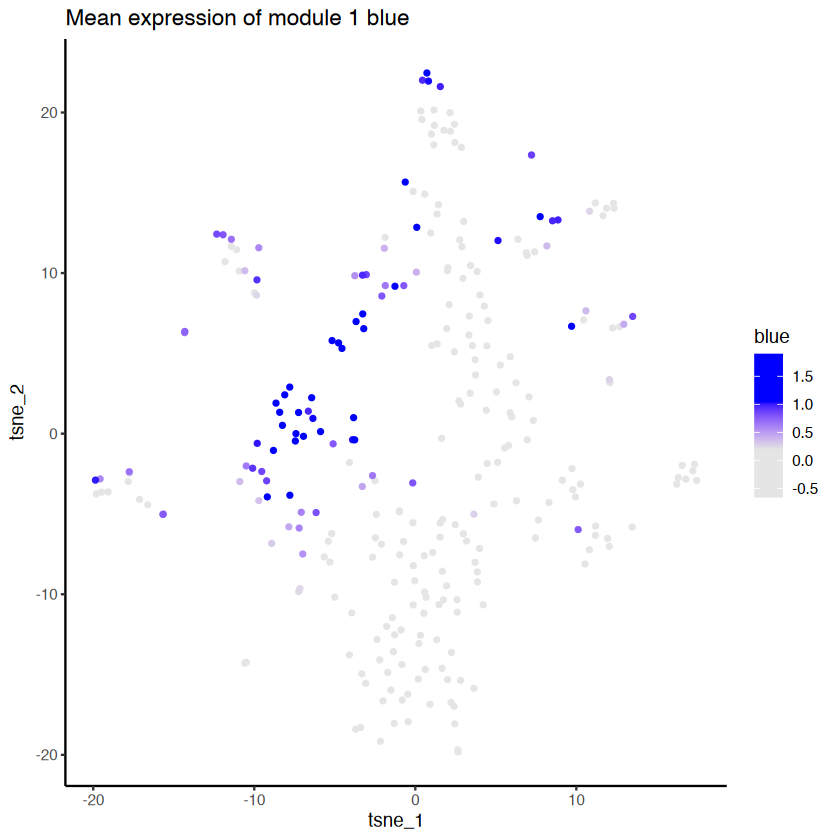

In [45]:
#Plot only the expression of the first module, "blue"
scW.p.expression(s.cells = seurat_sub,
                       scWGCNA.data = Fibro_sub.scWGCNA,
                       modules = 1)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



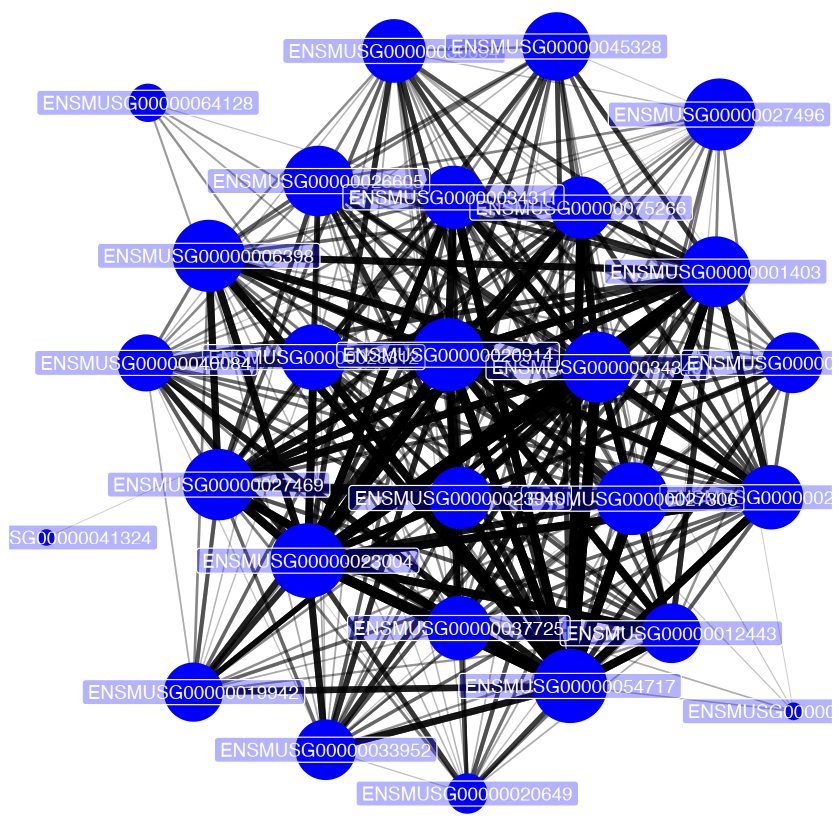

In [47]:
# First generate the networks in the scWCGNA object
Fibro_sub.scWGCNA = scWGCNA.networks(scWGCNA.data = Fibro_sub.scWGCNA)
#> Registered S3 method overwritten by 'GGally':
#>   method from   
#>   +.gg   ggplot2

# Plot the module "blue" as a network
scW.p.network(Fibro_sub.scWGCNA, module=1)

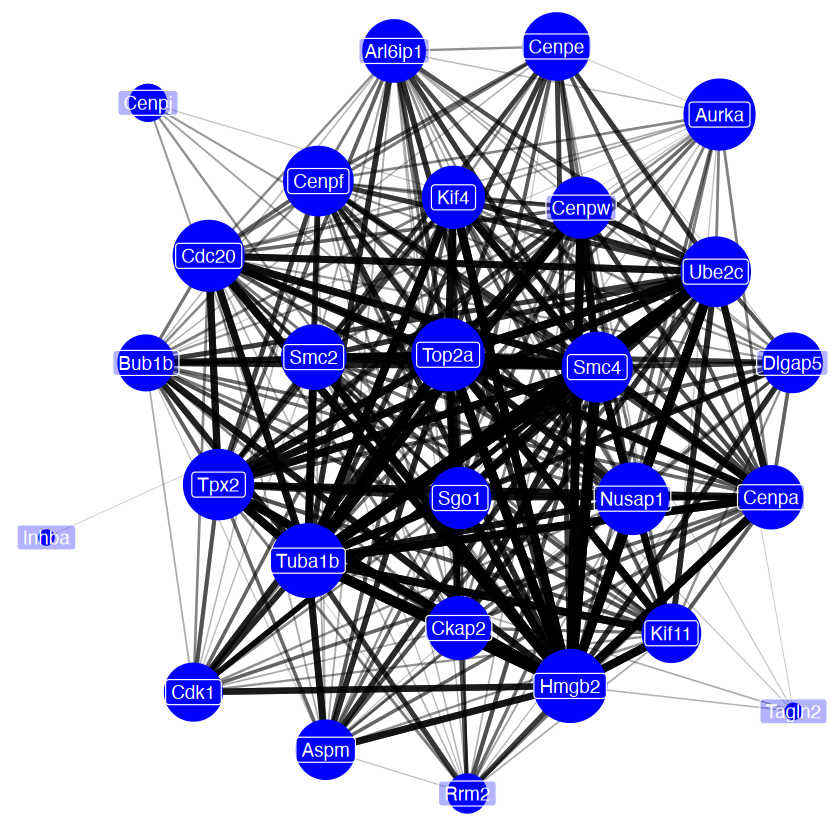

In [49]:
# Plot the module "blue" as a network. Again, we are using gene unique identifiers, not very informative.
# For this, we use the gene names translation we had before.
scW.p.network(Fibro_sub.scWGCNA, module=1, gnames = my.gnames)

## Module comparison accross samples


In [52]:
# A Seurat object with chicken limb cells
my.small_GgLimbHH29
#> An object of class Seurat 
#> 489 features across 288 samples within 2 assays 
#> Active assay: SCT (239 features, 196 variable features)
#>  1 other assay present: RNA
#>  3 dimensional reductions calculated: pca, xtsne, tsne

# We calculate pseudocells for this object
Gg.ps=calculate.pseudocells(my.small_GgLimbHH29, dims = 1:10)
#> Computing nearest neighbor graph
#> Computing SNN
#> Choosing seeds
#> 254 out of 288 Cells will be agreggated into 50 Pseudocells
#> Assining pseudocells
#> Aggregating pseudocell expression

# Our Seurat objects contain gene names equivalencies in the misc slot.
# We use them to biuld a table of orthologous genes
my.ortho = merge(seurat_sub@misc$gnames,my.small_GgLimbHH29@misc$gnames, by = "Gene.name")
head(my.ortho)
#>   Gene.name   Gene.stable.ID.x   Gene.stable.ID.y
#> 1         a ENSMUSG00000027596 ENSGALG00000039101
#> 2      Acan ENSMUSG00000030607 ENSGALG00000006725
#> 3     Acta2 ENSMUSG00000035783 ENSGALG00000006343
#> 4     Actc1 ENSMUSG00000068614 ENSGALG00000009844
#> 5   Adamts1 ENSMUSG00000022893 ENSGALG00000040342
#> 6   Adcyap1 ENSMUSG00000024256 ENSGALG00000014858
my.ortho=my.ortho[,2:3]

# We then run the comparative analysis
MmvGg.comparative = scWGNA.compare(scWGCNA.data = Fibro_sub.scWGCNA,
                                   test.list = list(Gg.ps),
                                   test.names = c("Gg"),
                                   ortho = my.ortho, # not needed unless reference and tests have different gene names
                                   ortho.sp = c(2))
#>   ..Excluding 15 genes from the calculation due to too many missing samples or zero variance.

An object of class Seurat 
489 features across 288 samples within 2 assays 
Active assay: SCT (239 features, 196 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, xtsne, tsne

Computing nearest neighbor graph

Computing SNN

Warning message:
“Command FindNeighbors.SCT.pca changing from SeuratCommand to SeuratCommand”
Choosing seeds

254 out of 288 Cells will be agreggated into 50 Pseudocells

Assining pseudocells

Aggregating pseudocell expression

Names of identity class contain underscores ('_'), replacing with dashes ('-')
This message is displayed once every 8 hours.


,Gene.name,Gene.stable.ID.x,Gene.stable.ID.y
,<chr>,<chr>,<chr>
1,a,ENSMUSG00000027596,ENSGALG00000039101
2,Acan,ENSMUSG00000030607,ENSGALG00000006725
3,Acta2,ENSMUSG00000035783,ENSGALG00000006343
4,Actc1,ENSMUSG00000068614,ENSGALG00000009844
5,Adamts1,ENSMUSG00000022893,ENSGALG00000040342
6,Adcyap1,ENSMUSG00000024256,ENSGALG00000014858


  ..Excluding 15 genes from the calculation due to too many missing samples or zero variance.


Warning message in bicor(datExpr, datME, , use = "p"):
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in bicor(datExpr, datME, , use = "p"):
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in bicor(datRef[, modGenes[[j]]], use = "p", quick = as.numeric(opt$quickCor)):
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in bicor(datTest[, modGenes[[j]]], use = "p", quick = as.numeric(opt$quickCor)):
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in bicor(datRef[, modGenes[[j]]], use = "p", quick = as.numeric(opt$quickCor)):
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in bicor(d

In [58]:
# We can see how many genes are present in each module, at each category. In the misc slot of the scWGCNA comparative list object
MmvGg.comparative$misc$modulefrac


# And the identity of the lost genes is found under the same slot
MmvGg.comparative$misc$geneslost


module,NA,NA,NA
<fct>,<int>,<dbl>,<dbl>
blue,27,26,26
brown,22,19,17
green,17,16,11
turquoise,33,33,33
yellow,19,18,10


,gene,module
,<chr>,<chr>
ENSMUSG00000090122,ENSMUSG00000090122,yellow
ENSMUSG00000050578,ENSMUSG00000050578,brown
ENSMUSG00000074457,ENSMUSG00000074457,green
ENSMUSG00000054200,ENSMUSG00000054200,brown
ENSMUSG00000029177,ENSMUSG00000029177,blue
ENSMUSG00000022015,ENSMUSG00000022015,brown
,gene,module
,<chr>,<chr>
ENSMUSG00000028435,ENSMUSG00000028435,green


In [60]:
# We can also plot these fractions as barplots, for each module we used for comparisons
scW.p.modulefrac(MmvGg.comparative)
#> Using module as id variables

ERROR: Error in `$<-.data.frame`(`*tmp*`, "diff", value = integer(0)): replacement has 0 rows, data has 5


Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_text()`).”


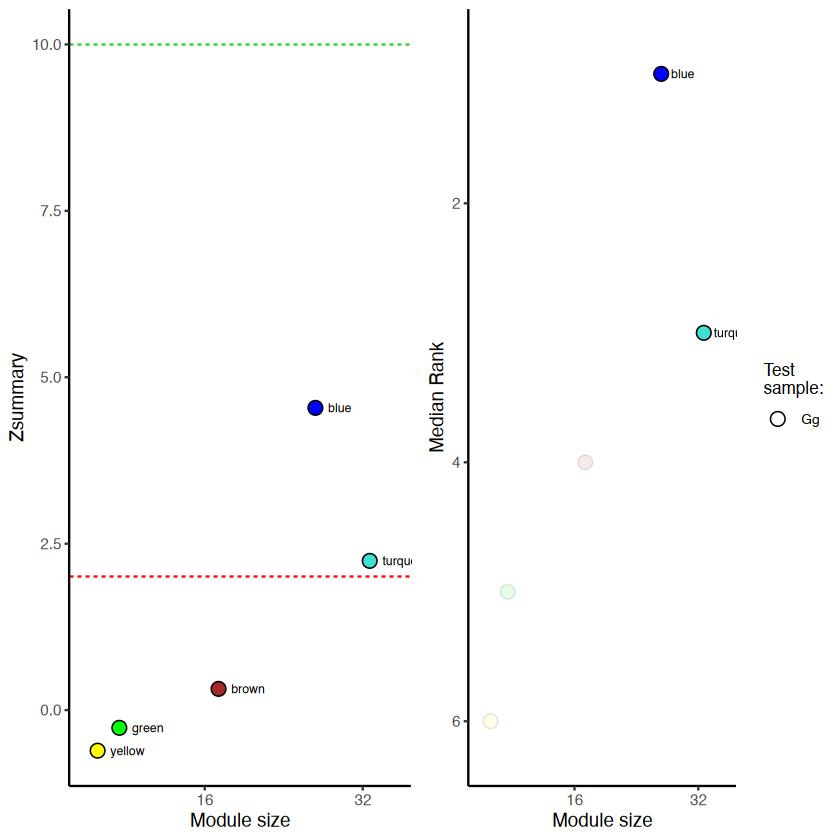

In [62]:
# Here we can plot the overall preservation and median rank.
scW.p.preservation(scWGCNA.comp.data = MmvGg.comparative,
                   to.plot=c("preservation", "median.rank"))
#> Warning: Removed 4 rows containing missing values (geom_text).

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_hline()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_hline()`).”


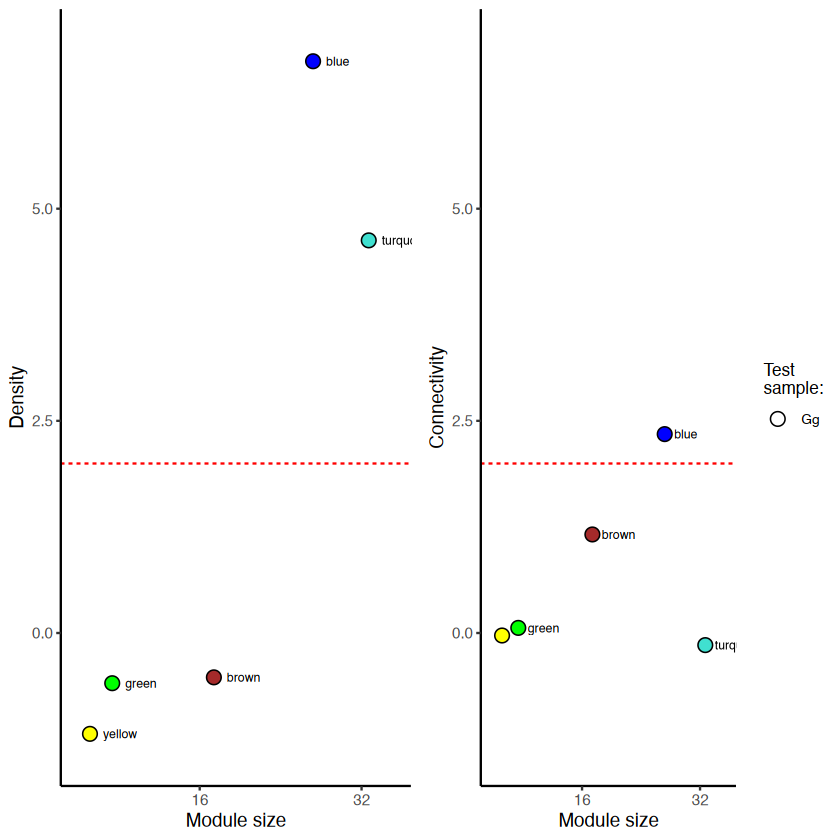

In [64]:
# We can also plot the preservation of density and connectivity.
scW.p.preservation(scWGCNA.comp.data = MmvGg.comparative,
                   to.plot=c("density", "connectivity"))
#> Warning: Removed 1 rows containing missing values (geom_hline).
#> Warning: Removed 1 rows containing missing values (geom_hline).

In [3]:
ls()

character(0)